# **Load the data and extract the features**

In [1]:
import os
import cv2
import numpy as np
from skimage import feature
import random
import matplotlib.pyplot as plt
%matplotlib inline

**Quantify the image using a HOG Descriptor**

In [2]:
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1", visualize=True)
    return features

In [3]:
def load_split(path):
    # grab the list of images in the input directory, then initialize
    # the list of data (i.e., images) and class labels
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]
        # load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        # threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image
        features, hog_image = quantify_image(image)
        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))

# **Training RandomForestClassifier**

In [4]:
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
def train_models(dataset):
    # initialize the models
    model = RandomForestClassifier(random_state=0)

    # define the path to the testing and training directories
    path = "./" + dataset
    trainingPath = os.path.sep.join([path, "training"])
    testingPath = os.path.sep.join([path, "testing"])
    # load the data
    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)
    # encode the labels
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)

    model.fit(trainX, trainY)
    y_pred = model.predict(testX)

    print(f'Performance of{dataset} on test-set')
    print(classification_report(testY, y_pred, target_names=le.classes_ ))

    return model

# Train the models on the spiral drawings
spiralModels = train_models('spiral')

Performance ofspiral on test-set
              precision    recall  f1-score   support

     healthy       0.78      0.93      0.85        15
   parkinson       0.92      0.73      0.81        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



In [6]:
# train the model on the wave-form drawings
waveModels = train_models('wave')

Performance ofwave on test-set
              precision    recall  f1-score   support

     healthy       0.69      0.73      0.71        15
   parkinson       0.71      0.67      0.69        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30



# **Testing On Sample Images and Visualize the predictions**

In [7]:
from skimage import exposure

def test_prediction(model, testingPath):
    # get the list of images
    testingPaths = list(paths.list_images(testingPath))
    #print(testingPaths)
    output_images = []
    # pick 15 images at random
    for i in range(15):
        image = cv2.imread(testingPaths[i])
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # pre-process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image and make predictions based on the extracted features
        features, hog_image = quantify_image(image)
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"

        # draw the colored class label on the output image and add it to
        # the set of output images
                
        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)

        # Rescale histogram for better display
        #output = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        output_images.append(output)

    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i], cmap=plt.cm.gray)
        plt.axis("off")
    plt.show()

**Spiral images**

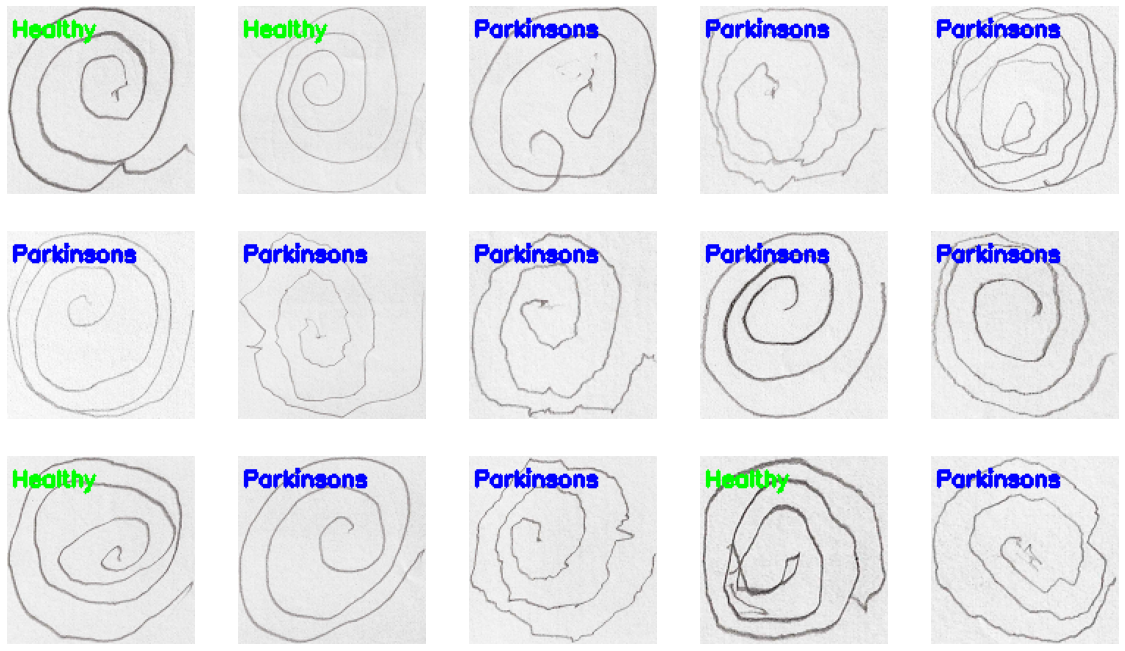

In [8]:
testingPath = os.path.sep.join(["./spiral", "testing"])
test_prediction(spiralModels, testingPath)

**Wave Images**

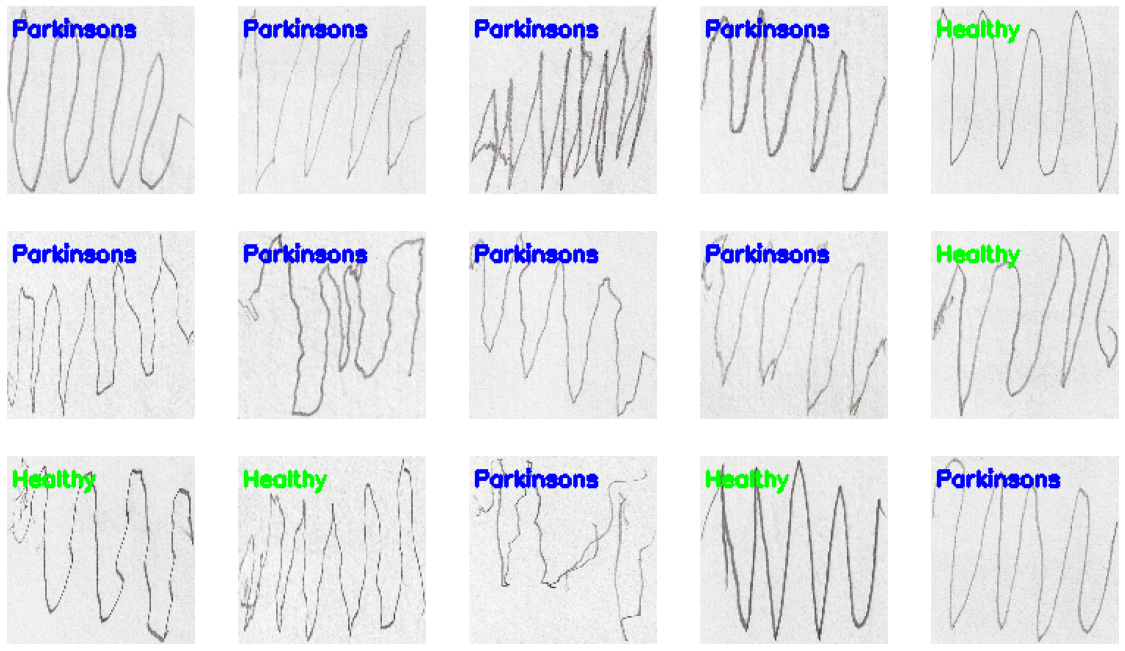

In [9]:
testingPath = os.path.sep.join(["./wave", "testing"])
test_prediction(waveModels, testingPath)